In [1]:
# Install the required libraries
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import Kaggle and OpenDatasets to download datasets from Kaggle
import opendatasets as od

# Download the dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/abdulhasibuddin/uc-merced-land-use-dataset'
od.download(dataset_url)

import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf

# Set the path to the image folder
data_path = 'uc-merced-land-use-dataset/UCMerced_LandUse/Images'

# Initialize image data and labels
image_data = []
labels = []

# Load the image dataset
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".tif"):
            # Read the image
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (128, 128))
            image = img_to_array(image)
            image_data.append(image)

            # Use the folder name as the label
            label = root.split(os.path.sep)[-1]
            labels.append(label)

# Convert to numpy arrays and normalize the images
image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define the teacher model (more layers)
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (128, 128, 3)
num_classes = len(lb.classes_)

# Build teacher and student models
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
# def lr_scheduler(epoch, lr):
#     return lr * tf.math.exp(-0.1) if epoch >= 10 else lr

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

# # Define distillation loss function
# def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
#     teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
#     y_true = tf.keras.activations.softmax(y_true / temperature)
#     y_pred = tf.keras.activations.softmax(y_pred / temperature)
#     teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
#     soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
#     hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#     return alpha * soft_loss + (1. - alpha) * hard_loss

# Evaluate models
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
#student_score = student.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
#print(f'Student test accuracy: {student_score[1] * 100:.2f}%')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akshayanand2002
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abdulhasibuddin/uc-merced-land-use-dataset


100%|██████████| 317M/317M [00:12<00:00, 27.4MB/s]



Training samples: 1680, Testing samples: 420
Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 281s 5s/step - accuracy: 0.0573 - loss: 3.0379 - val_accuracy: 0.0929 - val_loss: 2.9931 - learning_rate: 0.0100
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.0747 - loss: 2.9414 - val_accuracy: 0.0929 - val_loss: 2.9359 - learning_rate: 0.0100
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 281s 5s/step - accuracy: 0.1296 - loss: 2.8483 - val_accuracy: 0.1786 - val_loss: 2.5643 - learning_rate: 0.0100
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 331s 5s/step - accuracy: 0.2054 - loss: 2.5481 - val_accuracy: 0.2429 - val_loss: 2.2796 - learning_rate: 0.0100
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 314s 5s/step - accuracy: 0.2351 - loss: 2.3509 - val_accuracy: 0.2905 - val_loss: 2.1556 - learning_rate: 0.0100
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 326s 5s/step - accuracy: 0.3308 - loss: 2.0613 - val_accuracy: 0.3643 - val_loss: 1.9303 - learning_rate: 0.0100
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 316s 5s/st

In [2]:
# # Define distillation loss function
# def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
#     teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
#     y_true = tf.keras.activations.softmax(y_true / temperature)
#     y_pred = tf.keras.activations.softmax(y_pred / temperature)
#     teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
#     soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
#     hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
#     return alpha * soft_loss + (1. - alpha) * hard_loss

def distillation_loss(y_true, y_pred, teacher_preds, student_model, temperature=3.0, alpha=0.1):
    # Get predictions from the teacher model and apply temperature scaling
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)

    # Compute the soft loss and hard loss components
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Ensure the first layer has weights
    first_layer = student_model.layers[0]
    if hasattr(first_layer, 'weights') and len(first_layer.weights) > 0:
        # Extract weights from the first layer and compute nuclear norm
        first_layer_weights = first_layer.weights[0]  # Access weights directly
        singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
        nuclear_norm = tf.reduce_sum(singular_values)
    else:
        # If no weights exist, set nuclear_norm to 0
        nuclear_norm = 0

    # Return the combined loss
    return alpha * soft_loss + (1. - alpha) * hard_loss + alpha * nuclear_norm

# Compile and train the student model using distillation loss
student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds, student_model=student),
    metrics=['accuracy']
)

# Train the student model
student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Evaluate models
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')



Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.0483 - loss: 3.0445 - val_accuracy: 0.0643 - val_loss: 3.0445 - learning_rate: 0.0010
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.0928 - loss: 3.0445 - val_accuracy: 0.1071 - val_loss: 3.0445 - learning_rate: 0.0010
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.1294 - loss: 3.0444 - val_accuracy: 0.1881 - val_loss: 3.0444 - learning_rate: 0.0010
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.1761 - loss: 3.0444 - val_accuracy: 0.2286 - val_loss: 3.0442 - learning_rate: 0.0010
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.2433 - loss: 3.0443 - val_accuracy: 0.2905 - val_loss: 3.0442 - learning_rate: 0.0010
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3716 - loss: 3.0440 - val_accuracy: 0.3476 - val_loss: 3.0440 - learning_rate: 0.0010
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4445 - loss: 3.0438 - val_accurac

In [3]:
# Evaluate and print additional metrics for teacher and student models
from sklearn.metrics import classification_report
import time

def evaluate_model(model, x_test, y_test):
    # Predict the labels
    start_time = time.time()
    y_pred_probs = model.predict(x_test)
    inference_time = time.time() - start_time

    # Get the predicted classes
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate precision, recall, F1 score
    report = classification_report(y_true, y_pred, target_names=lb.classes_)

    # Print the metrics
    print(report)
    print(f"Inference Time: {inference_time:.4f} seconds")
    return y_pred_probs

print("=== Teacher Model Evaluation ===")
teacher_pred_probs = evaluate_model(teacher, x_test, y_test)

print("\n=== Student Model Evaluation ===")
student_pred_probs = evaluate_model(student, x_test, y_test)

=== Teacher Model Evaluation ===
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
                   precision    recall  f1-score   support

     agricultural       0.76      1.00      0.87        26
         airplane       0.74      0.96      0.83        26
  baseballdiamond       0.68      0.83      0.75        23
            beach       0.92      0.86      0.89        14
        buildings       0.45      0.33      0.38        15
        chaparral       0.96      0.96      0.96        23
 denseresidential       0.29      0.24      0.26        17
           forest       0.93      0.82      0.88        17
          freeway       0.35      0.50      0.41        16
       golfcourse       0.54      0.72      0.62        18
           harbor       0.83      0.91      0.87        22
     intersection       0.80      0.44      0.57        27
mediumresidential       0.36      0.50      0.42        24
   mobilehomepark       0.67      0.44      0.53        18
         overpass       0.80      0.67    

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step
=== Classification Report for Alpha: 0.1 ===
              precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       0.66      0.88      0.75        26
           2       0.90      0.83      0.86        23
           3       0.88      1.00      0.93        14
           4       0.19      0.40      0.26        15
           5       0.96      1.00      0.98        23
           6       0.40      0.35      0.38        17
           7       1.00      0.71      0.83        17
           8       0.35      0.56      0.43        16
           9       0.65      0.72      0.68        18
          10       0.80      0.73      0.76        22
          11       0.68      0.56      0.61        27
          12       0.29      0.17      0.21        24
          13       0.34      0.61      0.44        18
          14       0.68      0.72      0.70        18
          15       0.83      0.50      0.62      

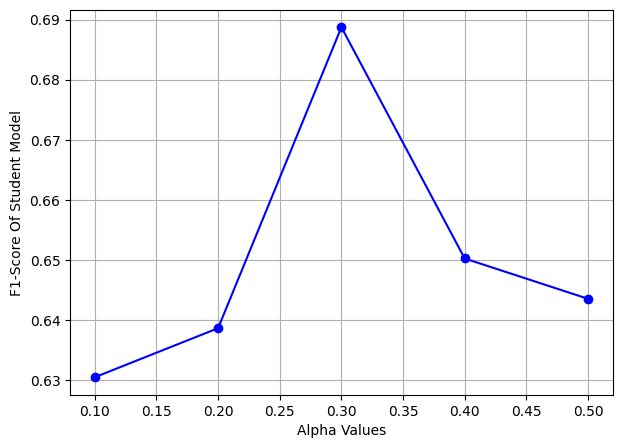

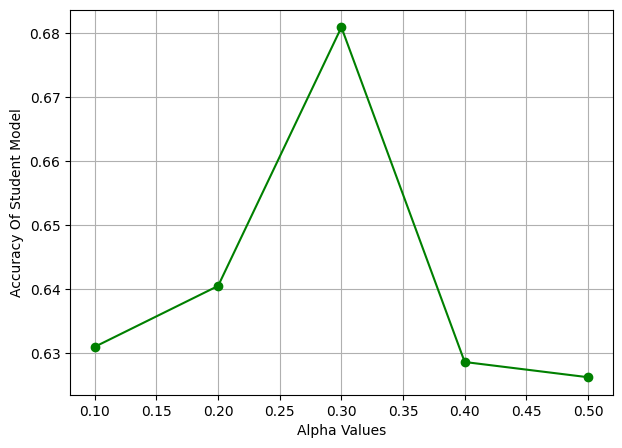

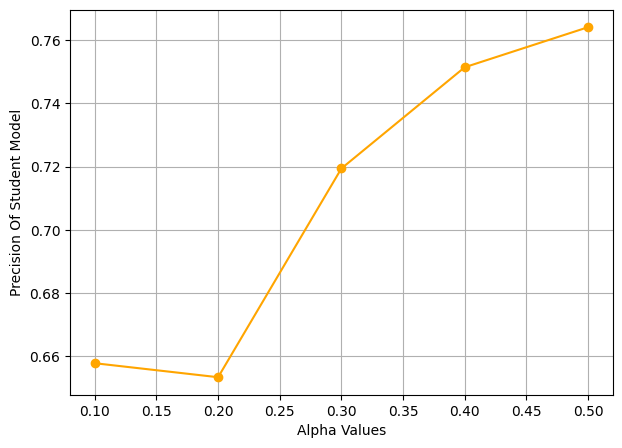

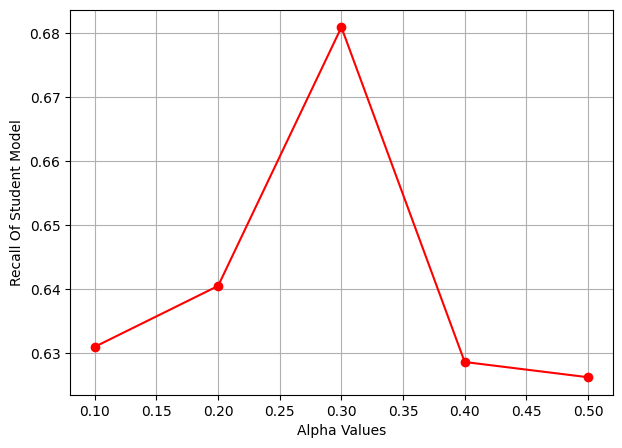

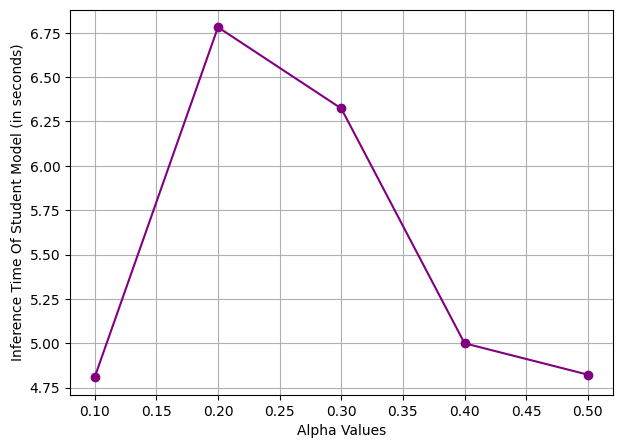

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler

# Define alpha values for experiments
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, student_model, temperature=3.0, alpha=alpha):
        # Scale teacher predictions and student predictions by temperature
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)

        # Calculate soft loss and hard loss
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Ensure the first layer has weights
        first_layer = student_model.layers[0]
        if hasattr(first_layer, 'weights') and len(first_layer.weights) > 0:
            # Extract first layer's weights from the student model and compute nuclear norm
            first_layer_weights = first_layer.weights[0]  # Access weights directly
            singular_values = tf.linalg.svd(first_layer_weights, compute_uv=False)
            nuclear_norm = tf.reduce_sum(singular_values)
        else:
            # If no weights exist, set nuclear_norm to 0
            nuclear_norm = 0

        # Combine losses with nuclear norm regularization
        return alpha * (soft_loss + nuclear_norm) + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds, student_model=student),
        metrics=['accuracy']
    )

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

# Plot F1-Score vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, f1_scores, marker='o', color='b')
plt.xlabel("Alpha Values")
plt.ylabel("F1-Score Of Student Model")
plt.grid(True)
plt.savefig("f1_score_vs_alpha.pdf")
plt.show()

# Plot Accuracy vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, accuracies, marker='o', color='g')
plt.xlabel("Alpha Values")
plt.ylabel("Accuracy Of Student Model")
plt.grid(True)
plt.savefig("accuracy_vs_alpha.pdf")
plt.show()

# Plot Precision vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, precisions, marker='o', color='orange')
plt.xlabel("Alpha Values")
plt.ylabel("Precision Of Student Model")
plt.grid(True)
plt.savefig("precision_vs_alpha.pdf")
plt.show()

# Plot Recall vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, recalls, marker='o', color='red')
plt.xlabel("Alpha Values")
plt.ylabel("Recall Of Student Model")
plt.grid(True)
plt.savefig("recall_vs_alpha.pdf")
plt.show()

# Plot Inference Time vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, inference_times, marker='o', color='purple')
plt.xlabel("Alpha Values")
plt.ylabel("Inference Time Of Student Model (in seconds)")
plt.grid(True)
plt.savefig("inference_time_vs_alpha.pdf")
plt.show()
